In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tools import _init_paths
from pathlib import Path
import torch
import torchvision.transforms as transforms

from PIL import Image, ImageOps
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 10.0, 8.0

import dataset
import models
from config import cfg as conf
from config import update_config
from utils.utils import model_key_helper
from core.inference import get_final_preds_match

import sys
import pandas as pd

/home/lin/Desktop/dlp_final/PRTR/two_stage/tools/../lib/models/__init__.py:16: UserWarning: No module named 'MultiScaleDeformableAttention'. deformable_pose_transformer will be unavailable
  warnings.warn(f'{ex}. deformable_pose_transformer will be unavailable')


In [2]:
class Visualizer:
    SKEL = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], 
            [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], 
            [2, 4], [3, 5], [4, 6], [5, 7]]

    def plot_results(self, img, pred, vis, scale):
        plt.figure()
        plt.imshow(img)
        ax = plt.gca()
        
        GREEN = [(5,6),(6,8),(8,10)]
        YELLOW = [(5,7),(7,9)]
        BLUE = [(5,11),(11,13),(13,15)]
        PINK = [(6,12),(12,14),(14,16)]

        vis_head = pred[:5][vis[:5] > 0]
        vis_body = pred[5:][vis[5:] > 0]

        for i, j in self.SKEL:
            ki = min(i, j) - 1
            kj = max(i, j) - 1
            # 0-4 head
            # 5,7,9,11,13,15 left
            # 6,8,10,12,14,16 right

            i, j = i - 1, j - 1
            src = pred[i]
            dst = pred[j]
            if vis[i] <= 0 or vis[j] <= 0:
                continue
            # face detail
            if ki < 5 and kj < 5:
                plt.plot([src[0], dst[0]],[src[1], dst[1]], linewidth=100, color=[250/255, 32/255, 98/255, 1], 
                        solid_capstyle='round', zorder=1)
            if ki >=5 and kj >= 5:
                pair = ki, kj
                trans = 1
                if pair in GREEN:
                    color = (38 / 255, 252 / 255, 145 / 255, trans)
                elif pair in YELLOW:
                    color = [250 / 255, 244 / 255, 60 / 255, trans]
                elif pair in BLUE:
                    color = [104 / 255, 252 / 255, 252 / 255, trans]
                elif pair in PINK:
                    color = [255 / 255, 148 / 255, 212 / 255, trans]
                else:
                    continue
                plt.plot([src[0], dst[0]],[src[1], dst[1]], linewidth=6.0 * scale, color=color, 
                         solid_capstyle='round', zorder=1)

            for pnt in vis_head:
                circle = plt.Circle((pnt[0], pnt[1]), 1.5 * scale * 1.2, fill=False, color='black', zorder=10)
                ax.add_artist(circle)
            for pnt in vis_body:
                circle = plt.Circle((pnt[0], pnt[1]), 3.0 * scale * 1.2, fill=False, color='black', zorder=10)
                ax.add_artist(circle)

            
        plt.axis('off')
        plt.show()


class Args:
    cfg = 'experiments/coco/transformer/w32_384x288_adamw_lr1e-4.yaml'
    opts = []
    modelDir = None
    logDir = None
    dataDir = None
    pretrained = 'lib/models/pytorch/pose_coco/pose_transformer_hrnet_w32_384x288.pth'

In [3]:
def inference(config, flip_pairs, input, size, target=None, target_weight=None, meta=None, transform=None):
    #c = meta['center']
    #s = meta['scale']
    outputs = model(transform(input)[None, ...])
    preds, _, preds_raw, preds_raw_ = get_final_preds_match(config, outputs, 
                                                np.array([size[0]/2,size[1]/2], dtype=np.float32), 
                                                np.array([2.,2.], dtype=np.float32))

    vis = np.ones((17,))
    # ignore face detail     
    vis[:5] = 0.
    vis[0] = 1.
    
    return preds_raw[0], vis, 1., preds_raw_

In [4]:
args = Args()
update_config(conf, args)
model = models.pose_transformer.get_pose_net(conf, is_train=False)
model.load_state_dict(model_key_helper(torch.load(args.pretrained, map_location='cpu')))

normalize = transforms.Compose([
    transforms.Resize((384, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_dataset = dataset.yoga(
    root = "/home/lin/Desktop/dlp_final/DATASET/TEST", mode = "test", size=(384, 288)
)
#valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
print(f"Loaded {len(valid_dataset)} images")

> Found 470 images...
Loaded 470 images


In [5]:
# VIS_INDICES = [300, 100]
keypoint_dict = {0:"nose", 1:"left_eye", 2:"right_eye", 3:"left_ear", 4:"right_ear", 5:"left_shoulder",
                 6:"right_shoulder", 7:"left_elbow", 8:"right_elbow", 9:"left_wrist", 10:"right_wrist", 
                 11:"left_hip", 12:"right_hip", 13:"left_knee", 14:"right_knee", 15:"left_ankle", 16:"right_ankle"}

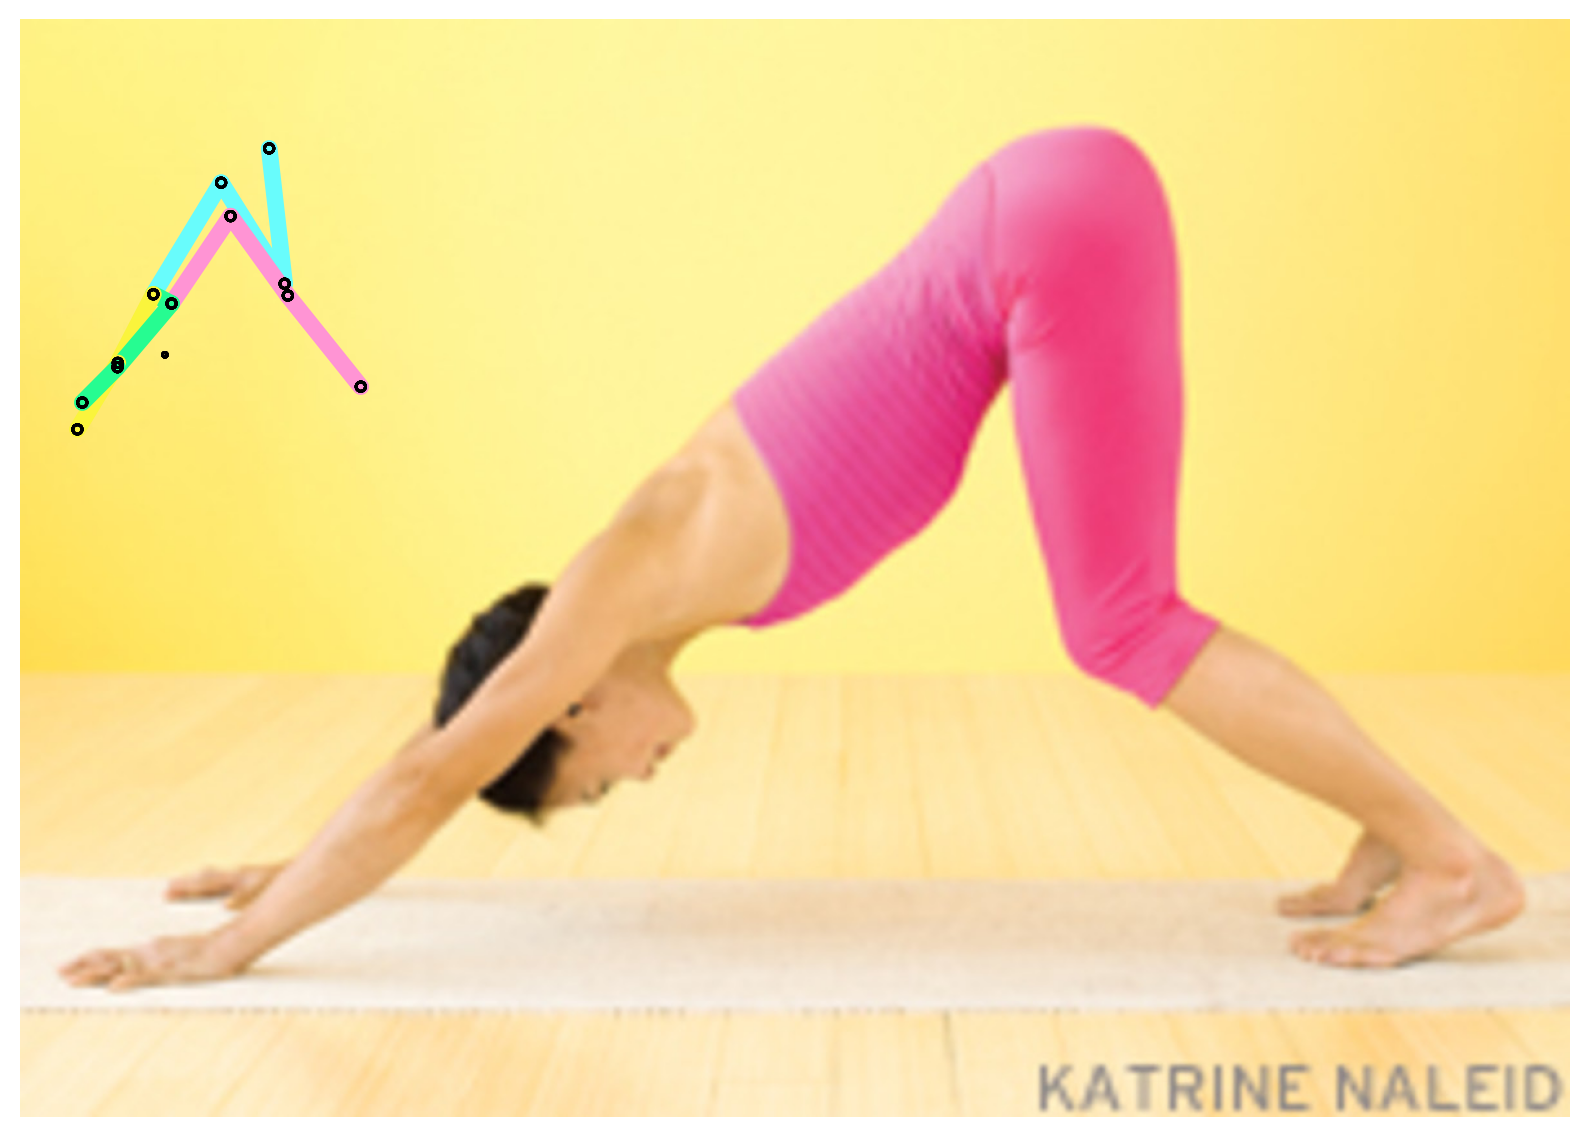

In [10]:
for image_idx in range(len(valid_dataset)):
    
    # get data
    input, label, w, h, path = valid_dataset[image_idx]
    
    # inference, preds_raw:[keypoints_id, x-coord, y-coord]
    preds_raw, vis, scale, _ = inference(conf, valid_dataset.flip_pairs, input, size=(w, h),
                                             target=None, target_weight=None, meta=None, transform=normalize)
    
    # coordinate normalization
    data = {'keypoint id': torch.arange(0,17),
            'keypoint name': keypoint_dict.values(),
            'vis': vis,
            'x-coord': preds_raw[:,0],
            'y-coord': preds_raw[:,1]
           }
    df = pd.DataFrame(data)
    
    # visualization 
    Visualizer().plot_results(input, preds_raw, vis, scale)

    break

In [11]:
df['x-coord norm'] = df['x-coord']
df['y-coord norm'] = df['y-coord']
df['x-coord norm'] = (df['x-coord norm'] - df['x-coord norm'].min()) / (df['x-coord norm'].max() - df['x-coord norm'].min())  
df['y-coord norm'] = (df['y-coord norm'] - df['y-coord norm'].min()) / (df['y-coord norm'].max() - df['y-coord norm'].min())
# df = df.astype(np.float64)

In [12]:
tmp = []
print(torch.from_numpy(df['x-coord'].values))
# *200 for visualize bigger keypoint image after normalization
tmp.append(torch.from_numpy(df['x-coord norm'].values)*200)
tmp.append(torch.from_numpy(df['y-coord norm'].values)*200)
tmp = torch.stack(tmp).transpose(0,1)
print(tmp.shape)
print(type(tmp[0][0].item()))

tensor([111.6854, 101.3975, 108.4409,  99.3255, 111.5414, 102.7638, 116.8252,
         75.2334,  74.9945,  43.9542,  47.7449, 155.2220, 162.5166, 204.3679,
        206.8351, 192.3954, 263.3321], dtype=torch.float64)
torch.Size([17, 2])
<class 'float'>


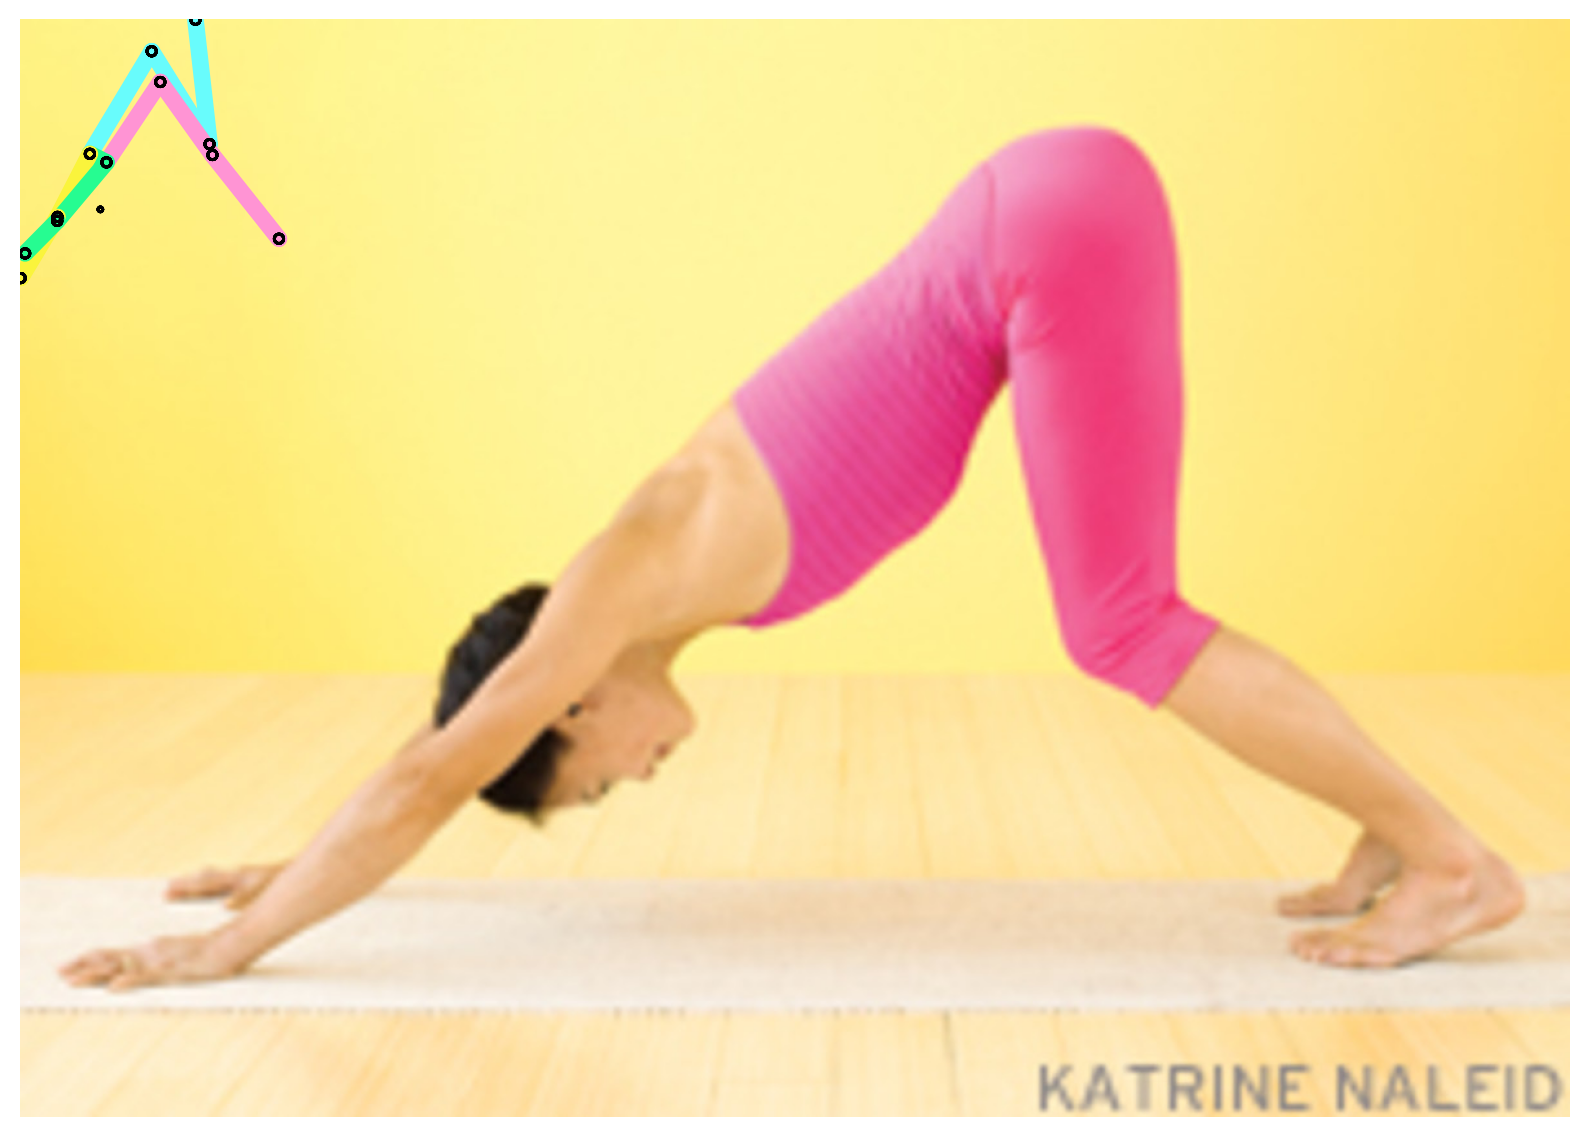

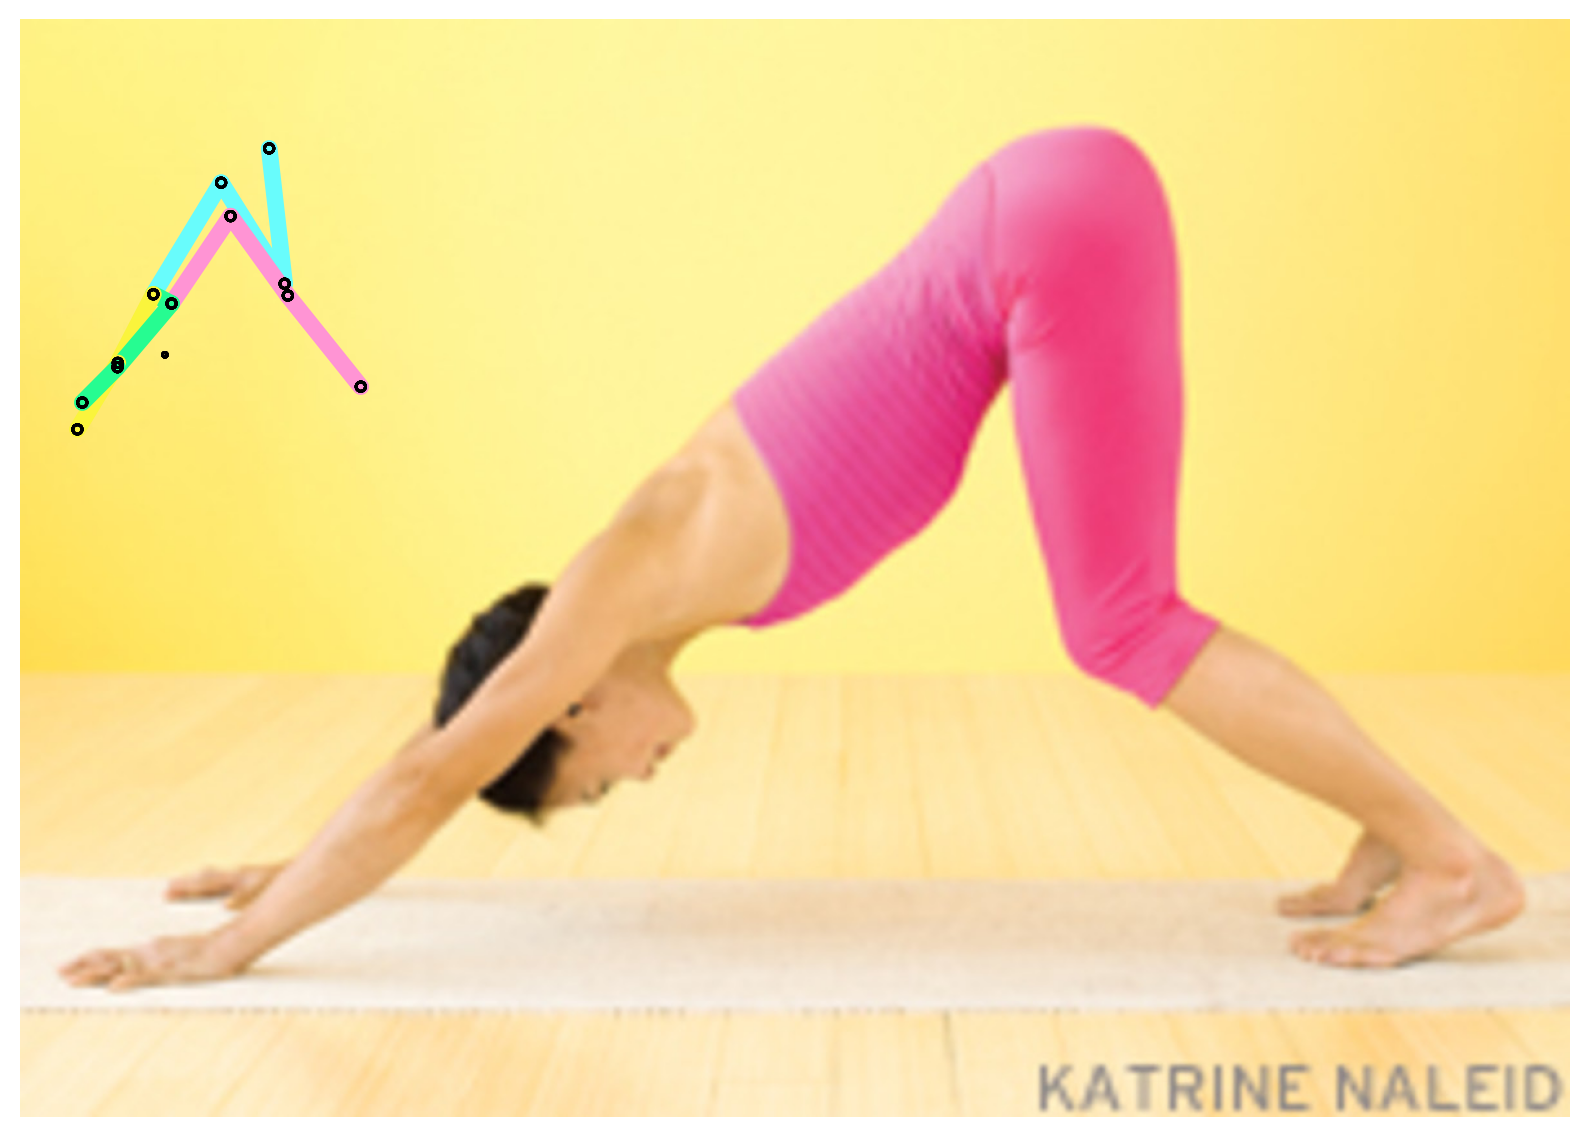

In [13]:
Visualizer().plot_results(input, tmp, vis, scale)
Visualizer().plot_results(input, preds_raw, vis, scale)